# Supply Chain Analysis and Optimization

In this notebook we will explore a dataset of an outbound logistics network and do a basic supply chain optimization. The dataset comes from [Dzalbs & Kalganova 2020](https://www.sciencedirect.com/science/article/pii/S0360835220303442?via%3Dihub) and represents real-world demand data from a global microchip producer. Specifically, we will use the data to calculate the supply chain cost for the given warehouse and transport options of the data. We will then create a simple linear programming cost optimization problem in which we optimize the assignment of orders to warehouses based on warehouse costs and capacities. We’ll do this with SciPy as well as with the PuLP linear programming package and compare results.

I will not do much exploratory data analysis here since we have a well documented dataset from the paper and have a narrowly defined problem scope. However, some additional visualization of the data can be found on the [public Tableau page](https://public.tableau.com/app/profile/alex.mcdaniel/viz/SupplyChainLogistics_17028331172440/Dashboard1).

## Import packages

In [1]:
import pandas as pd # for reading and maniuplating dataframes
import numpy as np #  general math calulations
import matplotlib.pyplot as plt # for visualization
import seaborn as sns # visualizations, some analysis

# scipy.optimize.milp requires scipy >=1.9.0
from scipy import stats
from scipy.optimize import minimize
from scipy.optimize import NonlinearConstraint, LinearConstraint
from scipy.optimize import milp

## Load & View Data

The datset we will be using is presented in [Dzalbs & Kalganova 2020](https://www.sciencedirect.com/science/article/pii/S0360835220303442?via%3Dihub), and can be downloaded from [figshare](https://brunel.figshare.com/articles/dataset/Supply_Chain_Logistics_Problem_Dataset/7558679). It is in the form of an excel file with 7 total tables. 


In [2]:
# Load data and print sheetnames
supply_chain = pd.ExcelFile('data/Supply_chain_logistics_problem.xlsx')
supply_chain.sheet_names

['OrderList',
 'FreightRates',
 'WhCosts',
 'WhCapacities',
 'ProductsPerPlant',
 'VmiCustomers',
 'PlantPorts']

The Dzalbs & Kalganova 2020 paper takes on a much more complicated supply chain problem implementing an Ant Colony Optimization scheme. For our much more simplified study we will not need all the data tables provided. The only tables we will use here are:

- OrderList

- FreightRates,

- WhCosts

- WhCapacities
 
These tables list actual orders, as well as the freight rates and costs and capacities of the warehouses.
The others (ProductsPerPlant, VmiCustomers, PlantPorts) contain information that constrains available combinations of products, customers, carriers and ports. These constraints are beyond the scope of what we'll be doing here. Next we can take a look at some details of the tables.

In [3]:
sheets = ['OrderList',
 'FreightRates',
 'WhCosts',
 'WhCapacities']

dfs = {}

# Load sheets into dictionary of dataframes
# view dataframe info
for sheet in sheets:
    dfs[sheet] = pd.read_excel(supply_chain, sheet_name=sheet)
    print(sheet)
    print(dfs[sheet].info())
    print('Duplicates: {}'.format(dfs[sheet].duplicated().sum()))
    print('\n\n')


OrderList
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9215 entries, 0 to 9214
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Order ID              9215 non-null   float64       
 1   Order Date            9215 non-null   datetime64[ns]
 2   Origin Port           9215 non-null   object        
 3   Carrier               9215 non-null   object        
 4   TPT                   9215 non-null   int64         
 5   Service Level         9215 non-null   object        
 6   Ship ahead day count  9215 non-null   int64         
 7   Ship Late Day count   9215 non-null   int64         
 8   Customer              9215 non-null   object        
 9   Product ID            9215 non-null   int64         
 10  Plant Code            9215 non-null   object        
 11  Destination Port      9215 non-null   object        
 12  Unit quantity         9215 non-null   int64         
 13  Weight  

In [4]:
dfs.keys()

dict_keys(['OrderList', 'FreightRates', 'WhCosts', 'WhCapacities'])

## Data info - Connections and nulls
The relevant table connections are:

WH from WhCosts <--> Plant Code from OrderList <--> PlantID from WHCapacities

and

Carrier from OrderList <--> Carrier FreightRates


This is a fairly manageable dataset, so in order to make the caluclations a little more straightforward we will merge the relevant tables

In [5]:
data = dfs['OrderList']

data = data.merge(dfs['WhCosts'], left_on='Plant Code', right_on = 'WH')
data = data.merge(dfs['WhCapacities'], left_on='WH', right_on = 'Plant ID')

# Use a left join here
data = data.merge(dfs['FreightRates'], how='left', left_on=['Carrier', 'Service Level', 'Origin Port', 'Destination Port'], right_on = ['Carrier', 'svc_cd', 'orig_port_cd','dest_port_cd'])
data.head()

,Order ID,Order Date,Origin Port,Carrier,TPT,Service Level,Ship ahead day count,Ship Late Day count,Customer,Product ID,...,orig_port_cd,dest_port_cd,minm_wgh_qty,max_wgh_qty,svc_cd,minimum cost,rate,mode_dsc,tpt_day_cnt,Carrier type
0,1.447296e+09,2013-05-26,PORT09,V44_3,1,CRF,3,0,V55555_53,1700106,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.447158e+09,2013-05-26,PORT09,V44_3,1,CRF,3,0,V55555_53,1700106,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.447139e+09,2013-05-26,PORT09,V44_3,1,CRF,3,0,V55555_53,1700106,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.447364e+09,2013-05-26,PORT09,V44_3,1,CRF,3,0,V55555_53,1700106,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.447364e+09,2013-05-26,PORT09,V44_3,1,CRF,3,0,V55555_53,1700106,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Service level of CRF indicates "Customer referred freight" which does not have transportation costs.

In [6]:
num_nonCRF = data[data['Service Level']!='CRF']['Order ID'].nunique()
num_CRF = data[data['Service Level']=='CRF']['Order ID'].nunique()

print('Transportation needed for {} orders, {} CRF orders'.format(num_nonCRF, num_CRF))

Transportation needed for 8361 orders, 854 CRF orders


In [7]:
#For now remove CRF
CRF_df = data[data['Service Level']=='CRF']


In [8]:
wght_cond = (data['Weight']>=data['minm_wgh_qty']) & (data['Weight']<data['max_wgh_qty'])
data_check = data[wght_cond].reset_index(drop=True)


In [9]:
# Above we saw that FreightRates has some duplicates
# We will simply drop these
print('duplicates: ', dfs['FreightRates'].duplicated().sum())

duplicates:  3


In [10]:
dfs['FreightRates'] = dfs['FreightRates'].drop_duplicates()

In [11]:
''' Note aso that there are several Transit options that only differ by their minimum cost and rate
 This is a bit troublesome to deal with. Later on we will simply take the average values for these 
 Freight Rate entries. Below we show the number of duplciates when excluding only 'minimum cost', 'rate' '''

dfs['FreightRates'][['Carrier', 'orig_port_cd', 'dest_port_cd', 'minm_wgh_qty',
       'max_wgh_qty', 'svc_cd', 'mode_dsc',
       'tpt_day_cnt', 'Carrier type']].duplicated().sum()


104

In [12]:
wght_cond = (data['Weight']>=data['minm_wgh_qty']) & (data['Weight']<=data['max_wgh_qty'])
#service_cond = (data['Service Level'] == data['svc_cd'])
#port_cond = (data['Origin Port'] == data['orig_port_cd']) & (data['Destination Port'] == data['dest_port_cd'])

data_wght_constraint = data[ wght_cond]

In [13]:
all_orders, cleaned_orders = data['Order ID'].unique(), data_wght_constraint['Order ID'].unique()


missing = list(set(all_orders).difference(set(cleaned_orders)))
print('Total orders {} \nOrders with valid transport {} \n\
Orders without valid transport info {} (incl. {} CRF)'.format(len(all_orders), len(cleaned_orders), len(missing), num_CRF))


Total orders 9215 
Orders with valid transport 6991 
Orders without valid transport info 2224 (incl. 854 CRF)


1370 orders are not compatible with any Freight options given the constraints. We could choose to only calulate the warhouse costs for these, but for now we will simply exclude them from our calulation. An additional 854 are CRF and thus do not contribute to the Transport costs.

In [14]:
cols = data.columns.to_list()

gp_cols = data.columns.to_list()
for x in ['tpt_day_cnt','minimum cost', 'rate']:
    gp_cols.remove(x)

In [15]:
grouped_df = data_wght_constraint[cols].groupby(gp_cols, as_index=False).mean()

grouped_df now includes all the sources that have valid transport information.

Need to include the V443 orders

In [16]:
data = pd.concat([grouped_df, CRF_df])
data.reset_index(inplace=True, drop=True)

### Define warehouse and transport costs 

The definitions of the cost functions are taken from the [Dzalbs & Kalganova 2020](https://www.sciencedirect.com/science/article/pii/S0360835220303442?via%3Dihub) paper.

In [17]:
def wh_cost(data):
    ''' Warehouse cost is the sum of the units quantity per order multipllied by 
        warehouse cost/unit
    '''
    cost  = (data['Unit quantity']*data['Cost/unit']).sum()
    return cost



# "The freight rate is determined based on total weight
#   on any given line pjcstm and the corresponding 
#    weight band in the freight rate table."
def tpt_cost(data):
    
    TCa = np.maximum(data['rate']*data['Weight'], data['minimum cost'])
    TCg = data['rate']*data['Weight'] 
    TC = np.where(data['mode_dsc']=='GROUND', TCg, TCa)
    TC_final = (np.where(data['Service Level']=='CRF', 0, TC) ).sum()
    
    return TC_final

### Calulate Cost
Once we have our data configured and our cost function defined we can calulate the cost for the Order Data from May 26 2013.

In [18]:

print('Warehouse cost is ${:.1f} million'.format(wh_cost(data)/1e6))
print('Transportation cost is ${:.1f} million'.format(tpt_cost(data)/1e6))
print('Total cost is ${:.1f} million'.format((tpt_cost(data) + wh_cost(data))/1e6))

Warehouse cost is $14.9 million
Transportation cost is $0.1 million
Total cost is $15.0 million


As we can see here, warehousing costs are the most dominant component of the total, accounting for >99% of the cost.
Thus, our optimaztion process will mainly be impacted by optimizing the warehouse costs.

## The Optimization Problem
Now lets work on an Optimaization problem using some fake order data. We use the fake data first in order to once again simplify the problem. Specifically, we will only focus on minimziing warehouse costs, and we will assume all orders have the same unit quantity, which directly affects the warehouse costs.

Thus, the problem is to determine the optimal number of orders to assign to each warehouse. We must take into consideration the Warehouse cost/unit and the daily capacities of orders that can be handled. 

In [19]:
# could merge instaed to unify WH info

dfs['WhCosts'] = dfs['WhCosts'].sort_values('WH').reset_index(drop=True)
wcosts = dfs['WhCosts']['Cost/unit']

dfs['WhCapacities'] = dfs['WhCapacities'].sort_values('Plant ID').reset_index(drop=True)
wcap = dfs['WhCapacities']['Daily Capacity ']

whs = dfs['WhCosts']['WH']

print('Max orders in a day {}'.format(wcap.sum()))

Max orders in a day 5791


The total number of orders we can process in a day is contrained by the total capacty of each warehouse.

In [20]:
# We choose some value of orders we want to consider
num_orders = 4000

new_order_cols = ['Origin Port','Service Level','Destination Port','Unit quantity','Weight']
new_orders = pd.DataFrame(np.repeat( dfs['OrderList'][new_order_cols].sample(1,random_state=1).values, num_orders, axis=0))
new_orders.columns = new_order_cols
#We wont really use this, but if lets generate unique Order IDs
new_orders['Order ID'] = np.random.choice(np.arange(num_orders), size=num_orders, replace=False)

new_orders.head()

,Origin Port,Service Level,Destination Port,Unit quantity,Weight,Order ID
0,PORT04,CRF,PORT09,251,1.941615,2562
1,PORT04,CRF,PORT09,251,1.941615,344
2,PORT04,CRF,PORT09,251,1.941615,2911
3,PORT04,CRF,PORT09,251,1.941615,3752
4,PORT04,CRF,PORT09,251,1.941615,3828


In [21]:

# grab the unit quantity for each of our orders
uq = new_orders['Unit quantity'].mode().iloc[0]


In [22]:
def random_assign(total, constraints):
    ''' Randomly assign a number (total) elements
        to len(constraints) open slots, obeying max numebr of 
        objects per slot as defnined by constraints
    '''
    rng = np.random.default_rng()
    samples = rng.multinomial(total, constraints / constraints.sum(), size=1000)
    try:
        return next(val for val in samples if np.all(val < constraints))
    except:
        return constraints

In [23]:

# Define our objective funtion (i.e. the warehouse storage costs)
def obj(x):
    ''' Input array containing the number 
        of orders for each warehouse. 
        
        Cost is calculated as the
        (warehouse cost/unit) X (unit quantity) X (number of orders)
        
        Output is cost in $1k    
    '''
    return (wcosts*uq*x).sum()/1e3


bounds = [(0,np.inf)]*len(wcosts) # disallow negative values



b_l = np.zeros(len(wcosts))
b_u = np.full_like(b_l, np.inf)
A = np.ones((len(b_l), len(wcosts)))


cons1 = LinearConstraint(A, b_l, b_u)
cons2 = NonlinearConstraint( lambda x: x.sum()-num_orders, 0,0) # Must account for all orders
cons3 = NonlinearConstraint( lambda x: min(wcap - x ), 0, np.inf) # Do not exceed warehouse capacity

cons = []
cons += [cons1]
cons += [cons2]
cons += [cons3]

# get random assignment of warehouses
print('get')
ra = random_assign(num_orders, wcap)
print(ra)
res = minimize(obj,x0 = ra,  bounds=bounds, constraints = cons, method='SLSQP')

print('Initial cost ${:.0f}k'.format(obj(ra)))
print('Optimized cost ${:.0f}k'.format(obj(res.x)))
print('Cost reduction {:.1f}%'.format((1-obj(res.x)/obj(ra))*100))

get
[781  99 679 382 270  34 173  12   5  81 238 146 344 385   8 295   7  58
   3]
Initial cost $658k
Optimized cost $508k
Cost reduction 22.8%


## Plot warehouse assignments

(0.0, 1200.0)

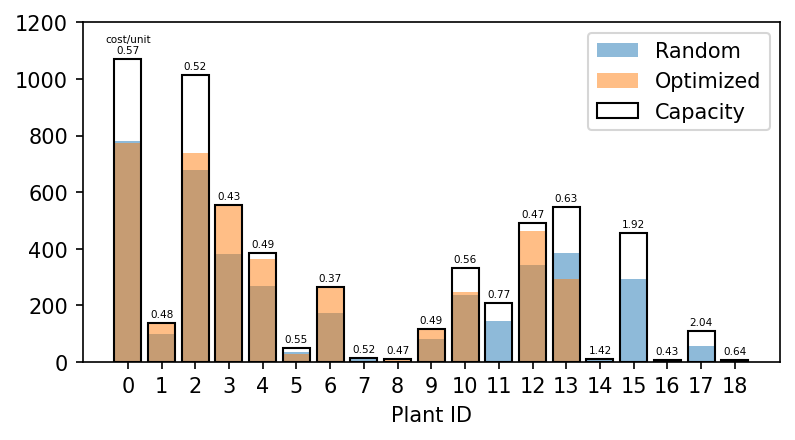

In [24]:
plt.figure(figsize=(6,3), dpi=150)
xvals = np.arange(len(whs))
plt.bar(x = xvals,height=ra, alpha=0.5, label='Random')
plt.bar(x = xvals,height=res.x, alpha=0.5, label='Optimized')
plt.bar(x = xvals,height=wcap, alpha=1, edgecolor='k',facecolor='none', label='Capacity')

plt.xticks([x for x in range(19)])

plt.legend()
plt.xlabel('Plant ID')



for i in xvals:
    if i==0:
        costlabel = 'cost/unit\n{:.2f}'.format(wcosts[i])
    else:
        costlabel = '{:.2f}'.format(wcosts[i])
    plt.text(i, wcap[i]+20, costlabel, fontsize=5, ha='center')

plt.ylim(ymax=1200)

## Repeat process to get cost reduction distribution

In [25]:
%%time

iters = 100
ra_costs = []
opt_costs = []
cost_reductions = []

errors = 0
unit_errors = []
relaxed_err= []


for i in range(iters):
    if (i+1)%10==0:
        print('{}/{}'.format(i+1, iters))

        
    # get random assignment of warehouses
    ra = random_assign(num_orders, wcap)


    res = minimize(obj, x0 = ra, bounds=bounds, constraints = cons, method='SLSQP', options={'maxiter':1000})
    result = np.round(res.x)
    if result.sum() != num_orders:
        unit_errors.append(result.sum()-num_orders)
        errors +=1
        
    relaxed_err.append(100*(1-obj(result)/obj(res.x)))
    cost_reductions.append((1-obj(result)/obj(ra))*100)

    ra_costs.append(obj(ra))
    opt_costs.append(obj(result))
    


10/100
20/100
30/100
40/100
50/100
60/100
70/100
80/100
90/100
100/100
CPU times: user 7min 36s, sys: 69.3 ms, total: 7min 36s
Wall time: 7min 40s


### Check differences due to rounding

Text(0.5, 0, '% difference due to rounding')

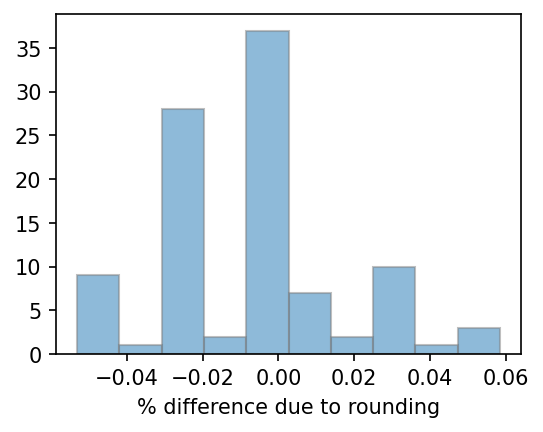

In [26]:
print('Warning: {} rounding errors totaling {} orders'.format(errors, np.sum(np.abs(unit_errors)) ))

# Does not account for capacity violations!
plt.figure(figsize=(4,3), dpi=150)
plt.hist(relaxed_err, alpha=0.5, edgecolor='grey')
plt.xlabel('% difference due to rounding')

mean cost reduction = 25.4%
deviation = 0.6%


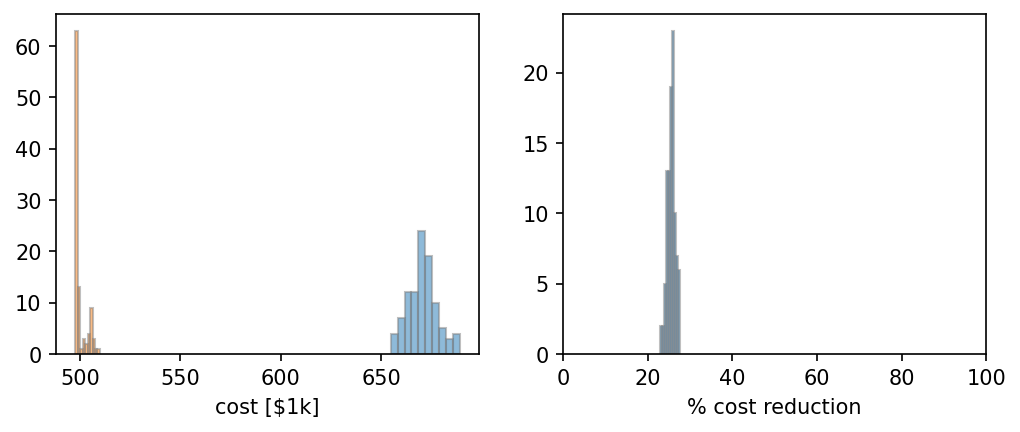

In [27]:

#Make as subplots
fig, ax = plt.subplots(1,2,figsize=(8,3), dpi=150)
ax[0].hist(ra_costs, alpha=0.5, edgecolor='grey', label = 'Random')
ax[0].hist(opt_costs, alpha=0.5, edgecolor='grey' ,label = 'Optimized')
ax[0].set_xlabel('cost [$1k]')

ax[1].hist(cost_reductions, alpha=0.5, edgecolor='grey')
ax[1].set_xlabel('% cost reduction')
ax[1].set_xlim(0,100)

print('mean cost reduction = {:.1f}%'.format(np.mean(cost_reductions)))
print('deviation = {:.1f}%'.format(100*np.std(opt_costs)/np.mean(opt_costs)))

## Summary of Results

We find that using this optimization method we are able to reduce costs by ~25% relative to a random assignment of orders to warehouses. The optimal cost has a ~1% standard deviation, which is actually a bit higher than I expected. Ideally, the function should minimize to the same value regardless of starting conditions. This indicates that there is some issue with the mimizer not consistently finding the global minimum. Even just allowing for more iterations could potentially resolve this, though overall 1% is not bad for this exercise.

While a 25% cost reduction is a great result, we must keep in mind that in the scipy implementation our orders assigned to warehouses are non-integer values. For this problem set up, we would actually want each order treated as an integer value, and thus the non integer ("relaxed" solution) will either be non optimal or violates constraints. We explored this a little bit above and saw that the effects of rounding to integer values did not change costs significantly (though we didnt check any violations of warehouse capacity constraints), but lets see if we can be more technically rigorous by implementing an integer programming method.

In the next section, we will use the PuLP linear programming library to implement a similar method that uses mixed-integer linear programming.

# Supply Chain optimization with PuLP

In [28]:
#!pip install pulp --progress-bar off

The [PuLP](https://coin-or.github.io/pulp/) library is a linear programming python library. We use it here as it will allow us to perform a mixed-integer linear programming solution to our optimization problem with our constraints. 

Also note that with PuLP we do not need to supply an intial guess as we did in scipy

In [29]:
import pulp


wcost_list = wcosts.to_list()
wcap_list = wcap.to_list()

num_vars = len(whs)

#define problem  model
model = pulp.LpProblem('model',pulp.LpMinimize)  

# Define integer varaibles (i.e. number of orders per warehouse)
orders = [pulp.LpVariable("x"+str(i), lowBound = 0,  cat = 'Integer') for i in range(num_vars)]


# Define Objective
model += pulp.lpSum([wcost_list[i] * uq*orders[i]/1e3 for i in range(num_vars)]), "Warehouse Cost"


# Define constraints
model += pulp.lpSum([orders[i] for i in range(num_vars)]) == num_orders, "Total Orders"

for i in range(num_vars):
    model += orders[i] <= wcap_list[i], 'Plant {} Capacity'.format(i)



In [30]:
print(model)

model:
MINIMIZE
0.14231102241732*x0 + 0.11985338325073283*x1 + 0.13936706990325226*x10 + 0.19405608037378935*x11 + 0.11789647120195978*x12 + 0.15921676416387132*x13 + 0.3551809075486018*x14 + 0.4818716844709608*x15 + 0.10766559335939214*x16 + 0.51109969371064*x17 + 0.1605803924741909*x18 + 0.12989297479799092*x2 + 0.10755432708220254*x3 + 0.12252424051637308*x4 + 0.1390761125040729*x5 + 0.09322740829378695*x6 + 0.1312371820982516*x7 + 0.1167328454431167*x8 + 0.12388905651921926*x9 + 0.0
SUBJECT TO
Total_Orders: x0 + x1 + x10 + x11 + x12 + x13 + x14 + x15 + x16 + x17 + x18
 + x2 + x3 + x4 + x5 + x6 + x7 + x8 + x9 = 4000

Plant_0_Capacity: x0 <= 1070

Plant_1_Capacity: x1 <= 138

Plant_2_Capacity: x2 <= 1013

Plant_3_Capacity: x3 <= 554

Plant_4_Capacity: x4 <= 385

Plant_5_Capacity: x5 <= 49

Plant_6_Capacity: x6 <= 265

Plant_7_Capacity: x7 <= 14

Plant_8_Capacity: x8 <= 11

Plant_9_Capacity: x9 <= 118

Plant_10_Capacity: x10 <= 332

Plant_11_Capacity: x11 <= 209

Plant_12_Capacity: x1

In [31]:
# Run the solver
model.solve()

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/armcdan/.local/lib/python3.9/site-packages/pulp/solverdir/cbc/linux/64/cbc /local_scratch/pbs.1783878.pbs02/3c43a266460b498b8f5b26f55ba5cb04-pulp.mps timeMode elapsed branch printingOptions all solution /local_scratch/pbs.1783878.pbs02/3c43a266460b498b8f5b26f55ba5cb04-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 25 COLUMNS
At line 121 RHS
At line 142 BOUNDS
At line 162 ENDATA
Problem MODEL has 20 rows, 19 columns and 38 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 497.699 - 0.00 seconds
Cgl0004I processed model has 1 rows, 19 columns (19 integer (0 of which binary)) and 19 elements
Cbc0012I Integer solution of 497.69879 found by greedy equality after 0 iterations and 0 nodes (0.00 seconds)
Cbc0001I Search completed - best objective 497.6987932001232, took 0 iterations and 0 node

1

In [32]:
res_dict = {}
for x in  model.variables():
    res_dict[x.name] = x.value()

    
pulp_res = []
for i in range(num_vars):
    pulp_res.append(res_dict['x'+str(i)])


(0.0, 1200.0)

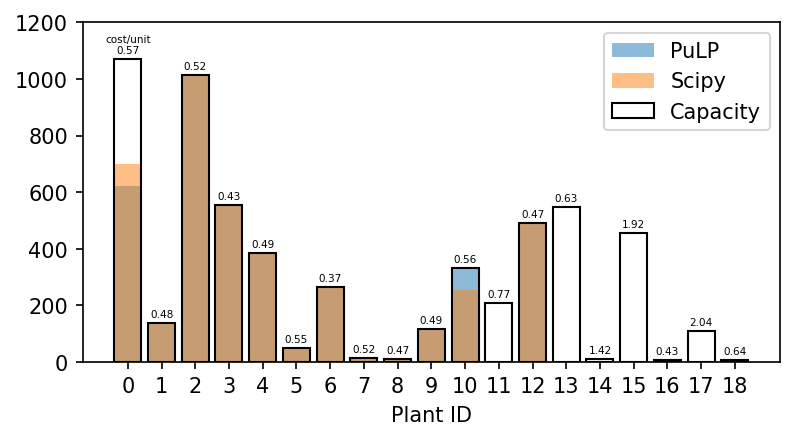

In [33]:
plt.figure(figsize=(6,3), dpi=150)
xvals = np.arange(len(whs))
plt.bar(x=xvals, height=pulp_res,alpha=0.5,  label='PuLP')
#plt.bar(x = xvals,height=ra, alpha=0.5, label='Random')
plt.bar(x = xvals,height=res.x, alpha=0.5, label='Scipy')
plt.bar(x = xvals,height=wcap, alpha=1, edgecolor='k',facecolor='none', label='Capacity')

plt.legend()
plt.xlabel('Plant ID')
plt.xticks(xvals)


for i in xvals:
    if i==0:
        costlabel = 'cost/unit\n{:.2f}'.format(wcosts[i])
    else:
        costlabel = '{:.2f}'.format(wcosts[i])
    plt.text(i, wcap[i]+20, costlabel, fontsize=5, ha='center')

plt.ylim(ymax=1200)

In [34]:
scipy_cost = obj(np.round(res.x))
scipy_cost_rel = res.fun
pulp_cost = pulp.value(model.objective)

print('Cost (SciPy): ${:.1f}k (relax ${:.1f}k)'.format(scipy_cost, scipy_cost_rel))
print('Cost (PuLP): ${:.1f}k'.format(pulp_cost))
print('PuLP Cost reduction: {:.1f}% (relax {:.1f}%)'.format((1 - pulp_cost/scipy_cost)*100, (1 - pulp_cost/scipy_cost_rel)*100))

Cost (SciPy): $498.1k (relax $498.0k)
Cost (PuLP): $497.7k
PuLP Cost reduction: 0.1% (relax 0.1%)


## Summary of Results with PuLP

Above we compare the results of the optimization using SciPy and PuLP. We see that the end results is pretty similar, with PuLP yielding a slightly lower cost. 

The figure above shows the minor differences in the warehouse assignments. Again they are very similar, with only slight deviations in two warehouses (Plant 0 and Plant 9).

Though the difference is small, PuLP also has the benefits of not requiring intitial values, handling the the integer nature of the varaibles and it is much faster.

# Additional analysis

In this exercise we compared two implementation of solving a simple supply chain optimization problem, wherein we were tasked with assigning orders to different warehouses based on the warehouse cost and capacity.

Our implementation were both straightforward linear programming minimzations. While this worked well in our very simplified problem, more complex tasks such as incorporating the different carriers and transportation methods would require alternative approaches. 

In a future project I plan to explore some of these more complex methods in order to perform an analysis that is more realistic and incorporates additonal levels of complexity. 

